# European Call Option Pricing

## Import Libraries

In [2]:
import numpy as np
from scipy.stats import norm
import sys
import datetime
import seaborn as sns 
import pandas as pd
from pandas_datareader import data as web
from GBM_returns import *
from BSM_option_valuation import *
from BSM_imp_vol import *
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from tabulate import tabulate

mpl.rcParams['font.family'] = 'serif'
sys.path.append('05_com')

## Market-Based Valuation Model

For a European call option on an index with strike and index level above the strike price (in-the-money) at maturity, the option holder receives the difference from option writer.

If the index level is below the strike, the option expires worless (out-of-the-money) at maturity, the option holder do not have to pay anything.

- in-the-money (ITM): a call(put) if S > K (S < K)
- at-the-money (ATM): a call(put) if S = K
- out-of-the-money (OTM): a call(put) if S < K (S > K)

In [5]:
def mbvaluation(K, min, max, n):
    S = np.linspace(min, max, n)  # index level values
    h = np.maximum(S - K, 0)      # inner values of call option
    
    # Graphical Output
    plt.figure(figsize=(7,5))
    plt.plot(S, h, lw=2.5)        # plot inner values at maturity
    plt.title('Market-Based Valuation Model for call option')
    plt.xlabel('index level $S_t$ at maturity')
    plt.ylabel('inner value of European call option')
    plt.grid(True)

K: 8000
Min: 4000
Max: 12000
n: 100


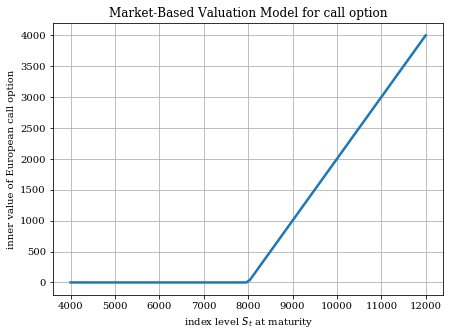

In [6]:
# input call option parameters:
K = (input("K: "))                            # strike
min = (input("Min: "))                        # min index level value
max = (input("Max: "))                        # max index level value
n= (input("n: "))                             # number of samples to generate.

mbvaluation(K, min, max, n)

## European call option price- Market-Based Valuation Model

In [19]:
def mbvaluation(S, K):
    return np.maximum(S - K, 0)

In [20]:
# input call option parameters:
K = (input("K: "))               # strike price
S = (input("S: "))               # spot price

mbvaluation(S, K)

K: 8000
S: 12000


4000

For a Euporan call option on an index with strike 8,000 and index level of 12,000, The option holder receives the difference of 4,000 from the option writer.

## Black-Scholes-Merton (BSM) model

The Black-Scholes-Merton model is a model of price variation over time of financial instruments and often be used to determine the price of a European call option. The persent value of the option is always above the (undiscounted) inner value. In this sense, the option's present value is composed of the inner value plus time value.

In [7]:
def bs_price(K, min, max, n, T, r, sigma):
    S = np.linspace(min, max, n)                                # index level values
    h = np.maximum(S - K, 0)                                    # inner values of call option
    C = [BSM_call_value(St, K, T, r, sigma) for St in S]        # calculate call option values using BSM model
    
    # Graphical Output
    plt.figure()
    plt.plot(S, h, 'b-', lw=2.5, label = 'inner value')         # plot inner values at maturity
    plt.plot(S, C, 'r-.', lw=2.5, label = 'present value')      # plot option present value
    plt.grid(True)
    plt.legend(loc=0)
    plt.title('Black-Scholes-Merton(BSM) pricing for ')
    plt.xlabel('index level $S_0$')
    plt.ylabel('present value $C(t=0)$')

r: 0.01
sigma: 0.05
K: 8000
Min: 4000
Max: 12000
T: 10
n: 100


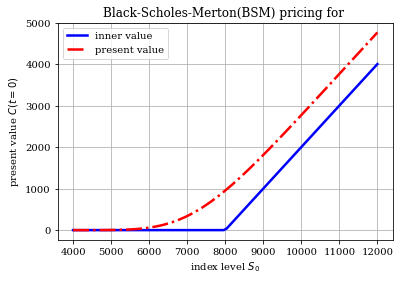

In [8]:
# input call option parameters:
r = (input("r: "))                            # risk-free rate
sigma = (input("sigma: "))                    # constant volatility
K = (input("K: "))                            # strike price
min = (input("Min: "))                        # min index level value
max = (input("Max: "))                        # max index level value
T= (input("T: "))                             # number of descrete time steps till maturity
n= (input("n: "))                             # number of samples to generate.


bs_price(K, min, max, n, T, r, sigma)

## European call option price- BSM model

In [14]:
# input call option parameters:
r = (input("r: "))                   # risk-free rate
sigma = (input("sigma: "))           # constant volatility
K = (input("K: "))                   # strike price
St = (input("St: "))                 # spot at time 0
T= (input("T: "))                    # number of descrete time steps till maturity

print "------------------\n"
print "Option price with BS is:", BSM_call_value(St, K, T, r, sigma)

r: 0.01
sigma: 0.05
K: 8000
St: 12000.
T: 10
------------------

Option price with BS is: 4761.57610236621


For a Euporan call option on an index with strike 8,000 and index level of 12,000, the present value of the call option is about 4,762 under BSM model as the BSM model take the time value into accounts.

## Black-Scholes-Merton (BSM) model with geometric Brownian motion (GBM)

In [99]:
#
# Simulate a Number of Years of Daily Stock Quotes
#

def simulate_gbm(S0, T, r, vol):
    
    # simulation parameters
    np.random.seed(250000)
    gbm_dates = pd.DatetimeIndex(start = '01-01-2008', end = '31-12-2017', freq = 'B') # set the datetime index
    M = len(gbm_dates)  # number of days
    I = 1               # index level paths
    dt = 1/252.         # fixed for simplicity
    df = np.exp(-r*dt)  # discount factor

    # stock price paths
    rand = np.random.standard_normal((M, I)) # random numbers
    S = np.zeros_like(rand)
    S[0] = S0           # initial values
    for t in range(1, M): #stock price paths (stochastic process)
        S[t] = S[t -1]*np.exp((r-vol**2/2)*dt+vol*rand[t]*np.sqrt(dt))
    
    # DataFrame created
    gbm = pd.DataFrame(S[:, 0], index=gbm_dates, columns=['index'])
    gbm['returns'] = np.log(gbm['index']/gbm['index'].shift(1))
    # Realized Variance
    gbm['rea_var'] = 252 *np.cumsum(gbm['returns']**2)/np.arange(len(gbm))
    # Realized Volatility
    gbm['rea_vol'] = np.sqrt(gbm['rea_var'])
    gbm = gbm.dropna()
    return gbm

# Return Sample Statistics and Normality Test

def quotes_statistics(data):
    print "RETURN SAMPLE STATISTICS"
    print "---------------------------------"
    print "Mean of Daily Log Returns %9.6f" % np.mean(data['returns'])
    print "Std of Daily Log Returns %9.6f" % np.std(data['returns'])
    print "Mean of Annua. Log Returns %9.6f" % (np.mean(data['returns'])*252)
    print "Std of Annua. Log Returns %9.6f" % (np.std(data['returns'])*np.sqrt(252))
    print "---------------------------------"
    print "Skew of Sample Log Returns %9.6f" % scs.skew(data['returns'])
    print "Skew Normal Test p-value %9.6f" % scs.skewtest(data['returns'])[1]
    print "---------------------------------"
    print "Kurt of Sample Log Return %9.6f" % scs.kurtosis(data['returns'])
    print "Kurt Normal Test p-value %9.6f" % scs.kurtosistest(data['returns'])[1]
    print "---------------------------------"
    print "Normal Test p-value %9.6f" % scs.normaltest(data['returns'])[1]
    print "---------------------------------"
    print "Realized Volatility %9.6f" % data['rea_vol'][-1]
    print "Realized Variance %9.6f" % data['rea_var'][-1]

#
# Grapraphical Output
#


# daily quotes and log returns
def quotes_returns(data):
    '''Plots quotes and returns.'''
    plt.figure(figsize=(9, 6))
    plt.subplot(211)
    data['index'].plot()
    plt.title('A single simulated path for daily log returns over a 10-year period')
    plt.ylabel('daily quotes')
    plt.grid(True)
    plt.axis('tight')

    plt.subplot(212)
    data['returns'].plot()
    plt.ylabel('daily log returns')
    plt.grid(True)
    plt.axis('tight')
        
    
# histogram of annualized daily log returns
def return_histogram(data):
    '''Plots a histogram of the returns'''
    plt.figure(figsize=(9, 5))
    x = np.linspace(np.min(data['returns']), np.max(data['returns']), 100 )
    plt.hist(np.array(data['returns']), bins=50, normed=True)
    y = norm.pdf(x, np.mean(data['returns']), np.std(data['returns']))
    plt.plot(x, y, linewidth=2)
    plt.title('The histogram of log return')
    plt.xlabel('log return')
    plt.ylabel('frequency/ probability')
    plt.grid(True)

#Q-Q plot of annualized daily log returns
def return_qqplot(data):
    '''Generates a Q-Qplot of the daily log returns'''
    plt.figure(figsize=(9, 5))
    sm.qqplot(data['returns'], line='s')
    plt.grid(True)
    plt.title('Q-Qplot of log return')
    plt.xlabel('theoretical quantile')
    plt.ylabel('sample quantiles')


# realized volatility
def realized_volatility(data):
    '''Plots the realized volatility.'''
    plt.figure(figsize=(9, 5))
    data['rea_vol'].plot()
    plt.title('Realized volatility for the simulated path')
    plt.ylabel('realized volatility')
    plt.grid(True)
    
    
# mean return, volatility and correlation (252 days moving = 1 year)
def rolling_statistics(data):
    '''Calculates and plots rollings statistics (mean, std, correlation).'''
    plt.figure(figsize=(11, 8))

    plt.subplot(311)
    mr = pd.rolling_mean(data['returns'], 252)*252
    mr.plot()
    plt.grid(True)
    plt.title('Rolling mean, rolling volatility, Rolling correlation of log return (252 days)')
    plt.ylabel('returns(252d)')
    plt.axhline(mr.mean(), color='r', ls= 'dashed', lw=1.5)

    plt.subplot(312)
    vo = pd.rolling_std(data['returns'], 252)*np.sqrt(252)
    vo.plot()
    plt.grid(True)
    plt.ylabel('volatility (252d)')
    plt.axhline(vo.mean(), color='r', ls='dashed', lw=1.5)
    vx=plt.axis()

    plt.subplot(313)
    corr=pd.rolling_corr(mr, vo, 252)
    corr.plot()
    plt.grid(True)
    cx=plt.axis()
    plt.axis([vx[0], vx[1], cx[2], cx[3]])
    plt.axhline(corr.mean(), color='r', ls='dashed', lw=1.5)

In [100]:
# model parameters
S0 = (input("S0: "))       # initial index level
T = (input("T: "))         # number of descrete time steps till maturity
r = (input("r: "))         # risk-free rate
vol = (input("vol: "))     # instantaneous volatility

simulate_gbm(S0, T, r, vol).head()

S0: 12000
T: 10
r: 0.01
vol: 0.05


,index,returns,rea_var,rea_vol
2008-01-02,11967.052285,-0.002749,0.001905,0.043646
2008-01-03,11953.190020,-0.001159,0.001122,0.033492
2008-01-04,11930.463306,-0.001903,0.001052,0.032435
2008-01-07,11948.318918,0.001496,0.000930,0.030495
2008-01-08,11977.502444,0.002440,0.001044,0.032309


In [102]:
data=simulate_gbm(S0, T, r, vol)

In [103]:
quotes_statistics(data)

RETURN SAMPLE STATISTICS
---------------------------------
Mean of Daily Log Returns  0.000023
Std of Daily Log Returns  0.003180
Mean of Annua. Log Returns  0.005855
Std of Annua. Log Returns  0.050486
---------------------------------
Skew of Sample Log Returns -0.016447
Skew Normal Test p-value  0.730950
---------------------------------
Kurt of Sample Log Return  0.120578
Kurt Normal Test p-value  0.206628
---------------------------------
Normal Test p-value  0.424617
---------------------------------
Realized Volatility  0.050487
Realized Variance  0.002549


- volatility- The annualized standard deviation of log returns equals almost exactly the instantaneous volatility = 0.05 of the geometric Brownian motion.


- skewness- the skewness is almost zero and the high p-value of the normal skewness test indicates that the distribution of the log returns is normal.


- kurtosis- although the kurtosis is slightly positive, the p-value of the normal kurtosis test neverthless also indicates normal distribution


- normality- the joint test for normality indicates a normal distribution with a p-value of 0.4246

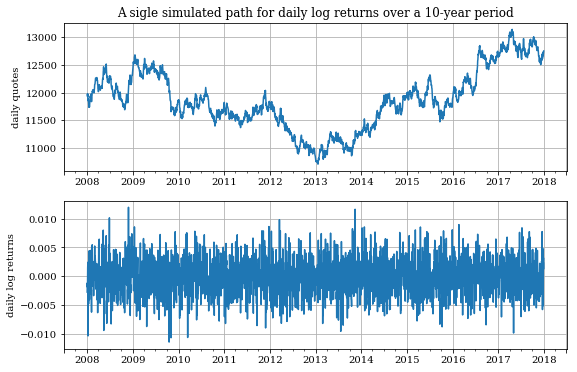

In [104]:
quotes_returns(data)

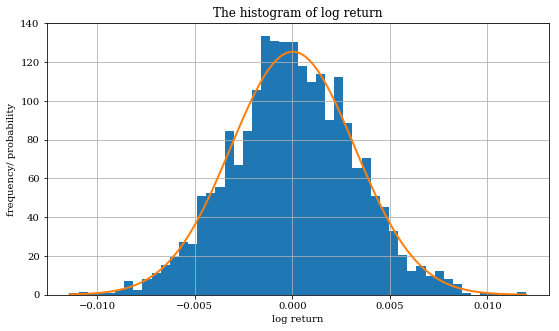

In [105]:
return_histogram(data)

<Figure size 648x360 with 0 Axes>

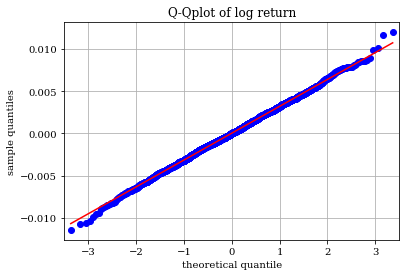

In [106]:
return_qqplot(data)

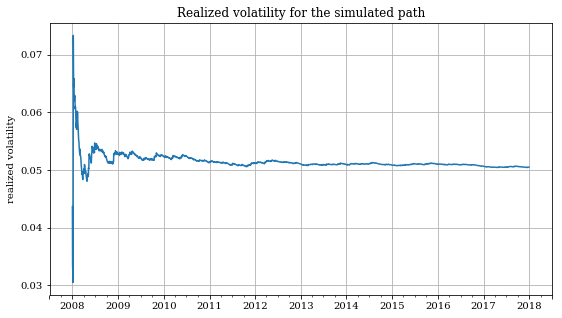

In [107]:
realized_volatility(data)

D:\Users\ivans\Anaconda2\lib\site-packages\ipykernel_launcher.py:116: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=252,center=False).mean()
D:\Users\ivans\Anaconda2\lib\site-packages\ipykernel_launcher.py:124: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=252,center=False).std()
D:\Users\ivans\Anaconda2\lib\site-packages\ipykernel_launcher.py:132: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=252).corr(other=<Series>)


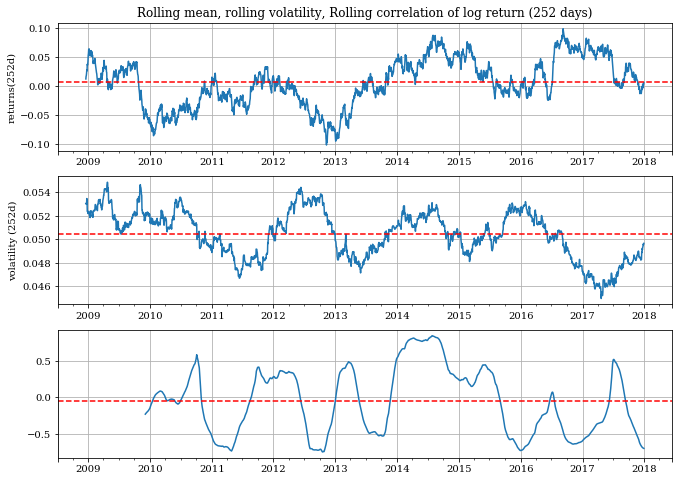

In [108]:
rolling_statistics(data)

# Using historical DAX data for simulation 

In [ ]:
DAX = web.DataReader('^GDAXI', data_source='yahoo', start='01-01-2008', end='31-12-2017')
DAX.rename(columns={'Adj Close' : 'index'}, inplace=True)
DAX['returns']=np.log(DAX['index']/DAX['index'].shift(1))
DAX['rea_var']=252*np.cumsum(DAX['returns']**2)/np.arange(len(DAX))
DAX['rea_vol']=np.sqrt(DAX['rea_var'])
DAX=DAX.dropna()

In [ ]:
DAX.head()

In [ ]:
quotes_statistics(DAX)

In [ ]:
return_histogram(DAX)

In [ ]:
return_qqplot(DAX)

In [ ]:
realized_volatility(DAX)

In [ ]:
rolling_statistics(DAX)

In [ ]:
# Pricing Data
pdate = pd.Timestamp('30-04-2014')

#
# EURO STOXX 50 index data
#

# URL of data file
es_url = 'http://www.stoxx.com/download/historical_values/hbrbcpe.txt'
# column names to be used
cols = ['Date','SX5P', 'SX5E', 'SXXP', 'SXXE', 'SXXF', 'SXXA', 'DK5F', 'DKXF', 'DEL']
# reading the data with pandas
es = pd.read_csv(es_url, #filename
                 header=None,
                 index_col=0,
                 parse_dates=True,
                 dayfirst=True,
                 skiprows=4,
                 sep=';', 
                 names=cols)

# deleting the helper column
del es['DEL']
S0 = es['SX5E']['30-04-2014']
r = -0.05

#
# Option Data
#

data =pd.HDFStore('./es50_option_data.h5', 'r')['data']

#
# BSM Implied Volatilities
#

def calculate_imp_vols(data):
    '''Calculate all implied volatities for the European call option'''
    data['Imp_Vol'] = 0.0
    tol = 0.30
    for row in data.index:
        t = data['Date'][row]
        M = data['Maturity'][row]
        ttm = (M-t).days / 365.
        forward = np.exp(r*ttm)*S0
        if (abs(data['Strike'][row]-forward)/forward)< tol:
            call = call_option(S0, data['Strike'][row], t, M, r, 0.2)
            data['Imp_Vol'][row] = call.imp_vol(data['Call'][row])
    return data

#
# Graphical Output
#
markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']
def plot_imp_vols(data):
    '''Plot the implied volatilites'''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 5))
    
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity']==mat) & (data['Imp_Vol'] > 0)]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values, 'b%s' % markers[i], label=str(mat)[:10])
        
    plt.grid()
    plt.legend()
    plt.xlabel('strike')
    plt.ylabel('implied volatility')

In [ ]:
calculate_imp_vols(data).tail()

In [ ]:
plot_imp_vols(data)

## Monte Carlo Simulation

The Monte Carlo Simulation is a probability distribution technique used to understand the impact of risk and uncertainty in financial, project management, cost, and other forecasting models. It calculates results over and over, each time using a different set of random values from the probability functions. Pricing the financial dervative such as European Call Option can be broadly split into finding expectations analytically or via a simulation.

In [ ]:
def mcprice(n, r, sigma, K, St, T):

    disc = np.exp(-r*T)  
    vol = sigma*np.sqrt(T)
    
    # simulate N terminal prices by using normal distribution
    rands=np.random.normal(size=n)
    
    # calculate price analytically using Monte Carlo Simulation
    ST=St*np.exp((r-0.5*sigma*sigma)*T + vol*rands)
    payoff = np.multiply([p if p > 0 else 0 for p in ST-K], disc)   #inner value
    MCprice = np.mean(payoff,axis=0)
    print "----------------\n"
    print "Option price with MC is:", MCprice
    
    #Plot the Histogram of terminate price using Monte Carlo Probabilistic Simulation
    ax = sns.distplot(payoff, kde=True, color='red', bins=30)
    ax.set_title("Probability density of call option price using Monte Carlo Simulation", fontsize=15)
    ax.set(xlabel='price', ylabel='posibilities')
    return ax


In [ ]:
# input call option parameters:
n = (input("n: "))                            # number of seed
r = (input("r: "))                            # risk-free rate
sigma = (input("Sigma: "))                    # constant volatility
K = (input("K: "))                            # strike
St = (input("St: "))                          # spot at time 0
T= (input("T: "))                             # number of descrete time steps till maturity


mcprice(n, r, sigma, K, St, T)